# Data Cleaning File
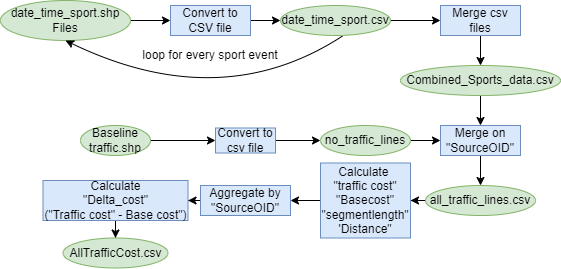

This file goes through multiple data cleaning steps for our road line datasets. Warning: due to the large size of all our road line data, this file takes a LONG time to run every chunk of code.

Credits: chat.openai.com and draw.io

## Import Statments

In [13]:
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath) + '\\final_files'
os.chdir(file_path)
arcpy.env.workspace = file_path
print(arcpy.env.workspace)

##geopandas to read shapefile
import geopandas as gpd
##os for working with file path
import os
##datetime to check timestamp of event
from datetime import datetime
##Linestring to save our road lines to WKT
from shapely.geometry import LineString
#pandas to read csv files as dataframes
import pandas as pd
import warnings

C:\Users\Track\OneDrive\Documents\ArcGIS\Projects\ArcIIFinalTransitProject\final_files


# Create CSV From the Event Shapefiles

This code reads in the shapefile for each large event, and then converts that shapefile into a CSV under the same name.

In [18]:
#function to check if the time is evening (after 3:01pm)
##returns True (time is after 3:01pm) or False (before 3:01pm)
def is_evening(time_str):
    #convert the time string to a time object
    time = datetime.strptime(time_str, '%I%M%S%p')
    #check for "Evening?"
    return time.hour > 15 or (time.hour == 15 and time.minute > 1)

#function to read a shapefile and save it to CSV (if a doesn't already exist)
def process_and_save_shapefile(filepath):
    #create name of CSV file we want to save
    ##os.path.basename -- gets the file name we want (XXXX.shp)
    ##os.path.splittext -- splits the text to remove '.shp'
    ##add .csv to the end of the file name
    csv_filename = os.path.splitext(os.path.basename(filepath))[0] + ".csv"
    #Convert just file name to full file path
    csv_filepath = os.path.join(os.path.dirname(filepath), csv_filename)
    #chck if corresponding CSV file already exists
    if os.path.exists(csv_filepath):
        #end the function if the csv file exists
        print(f"CSV file already exists for {os.path.basename(filepath)}, skipping.")
        return
    
    #read the shapefile to a geopandas dataframe
    gdf = gpd.read_file(filepath)
    
    #the filename has important info (date, time, and sporting type)
    ##we need to pull that info and add it in our csv
    filename = os.path.basename(filepath)
    #filename.split('_') --> get each chunk of text between each underscore
    ##sport event is the last chunk of text, ignoring .shp end of file
    sport = filename.split('_')[-1].replace('.shp', '')
    ##date is the first chunk of text, ignoring the first character 'c'
    date_str = filename.split('_')[0][1:]
    ##timestamp is the second chunk of text
    timestamp = filename.split('_')[1]
    #convert date to datetime
    date = datetime.strptime(date_str, '%m%d%Y')
    #check if the date is a weekday? (True if date.weekday() < 5)
    ##date.weekday --> Monday = 1, Tuesday = 2 ...
    weekday = date.weekday() < 5
    #call our is_evening function
    evening = is_evening(timestamp)

    #create new columns for 'Latititude', 'Longitude', and 'geometry_wkt'
    ##get the 'Latitude' and 'Longitude' based on the center of each line string
    gdf['Latitude'] = gdf['geometry'].centroid.y
    gdf['Longitude'] = gdf['geometry'].centroid.x
    #convert geometry to well known text so we can easily keep it in shapefile
    gdf['geometry_wkt'] = gdf['geometry'].to_wkt()
    
    #select certain columns to keep and rename them to something more usable
    columns_to_keep = {
        'SourceOID': 'SourceOID',
        'FromCumul1': 'TimeFrom',
        'FromCumu_2': 'DistanceFrom',
        'ToCumul_Tr': 'TimeTo',
        'ToCumul_Ki': 'DistanceTo',
        'geometry_wkt': 'geometry_wkt',
        'Latitude': 'Latitude',
        'Longitude': 'Longitude'
    }
    gdf = gdf.rename(columns=columns_to_keep)[list(columns_to_keep.values())]

    #add the extra info we pulled and calculated from the file name
    gdf['Sport'] = sport
    gdf['Date'] = date_str
    gdf['Timestamp'] = timestamp
    gdf['Weekday?'] = weekday
    gdf['Evening?'] = evening
    
    #save to CSV
    gdf.to_csv(csv_filepath, index=False)
    print(f"Saved: {csv_filepath}")

#folder where all the shapefiles are stored
directory = arcpy.env.workspace + "\\outputs"

#process each shapefile and save as a CSV, skip if CSV already exists
count = 1
#this ignores an error in geopandas for reading files, makes things nicer to read
import warnings
warnings.filterwarnings("ignore")
#iterate and read every shapefile in the folder
for filename in os.listdir(directory):
    if filename.endswith(".shp"):
        print(count)
        #create a full filepath for the shapefile
        filepath = os.path.join(directory, filename)
        process_and_save_shapefile(filepath)
        count += 1
print("Processing complete. Skipped files where CSV already exists.")

Processing complete. Skipped files where CSV already exists.


# Merge CSV into one giant CSV

This will read in all our event CSV files and append all the rows into one larger CSV file.

In [22]:
#the path to the folder holding all the csv files
directory_path = arcpy.env.workspace + "\\outputs"

#create a list to hold all our data together
dfs = []

count = 1
#look at every file in the folder
for filename in os.listdir(directory_path):
    #find each csv file
    if filename.endswith('.csv'):
        print(count)
        #convert file name to full file path
        file_path = os.path.join(directory_path, filename)
        #read the CSV file and append it to the list
        dfs.append(pd.read_csv(file_path))
        count += 1

#concatenate (combine) all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

#save the combined DataFrame to a new CSV file
combined_df.to_csv(arcpy.env.workspace + "\\outputs\\combined_sports_data.csv", index=False)
print("All CSV files have been combined into a single file.")

All CSV files have been combined into a single file.


# Convert Baseline into CSV

This is a slightly modified version of the save shapefile function above to save the baseline shape file to a csv.

In [21]:
#function to process and save each shapefile as a CSV, skip if CSV already exists
def process_and_save_shapefile(filepath):
    #check if corresponding CSV file already exists
    csv_filename = os.path.splitext(os.path.basename(filepath))[0] + ".csv"
    csv_filepath = os.path.join(os.path.dirname(filepath), csv_filename)
    
    if os.path.exists(csv_filepath):
        print(f"CSV file already exists for {os.path.basename(filepath)}, skipping.")
        return
    
    #read the baseline shapefile
    gdf = gpd.read_file(filepath)

    # Calculate the centroid coordinates
    gdf['Latitude'] = gdf['geometry'].centroid.y
    gdf['Longitude'] = gdf['geometry'].centroid.x
    gdf['geometry_wkt'] = gdf['geometry'].to_wkt()
    
    #select and rename columns. We only need a few for the baseline data set
    columns_to_keep = {
        'SourceOID': 'SourceOID',
        'FromCumul1': 'BaseTimeFrom',
        'ToCumul_Tr': 'BaseTimeTo',
    }
    gdf = gdf.rename(columns=columns_to_keep)[list(columns_to_keep.values())]
    
    #save the shape datframe to CSV
    gdf.to_csv(csv_filepath, index=False)
    print(f"Saved: {csv_filepath}")

#folder where the shapefile is stored
filepath = arcpy.env.workspace + "\\no_traffic_lines.shp"

#process shapefile and save as a CSV, skip if CSV already exists
process_and_save_shapefile(filepath)
print("Processing complete. Skipped files where CSV already exists.")

CSV file already exists for no_traffic_lines.shp, skipping.
Processing complete. Skipped files where CSV already exists.


# Add Baseline Columns to CSV

This adds the data from the baseline dataset into the big event dataset

In [23]:
#read both sets of data
df1 = pd.read_csv(arcpy.env.workspace + "\\outputs\\combined_sports_data.csv")
df2 = pd.read_csv(arcpy.env.workspace + "\\no_traffic_lines.csv")

#merge the datasets on the 'SourceOID' column
merged_df = df1.merge(df2, on='SourceOID')

#save the merged dataset to a new spot
merged_df.to_csv(arcpy.env.workspace + "\\All_Traffic_Lines.csv", index=False)

# Extra calculations

This calculates the cost of each road segment, along with segment length and distance from the end location

In [2]:
#read in the merged dataset
df = pd.read_csv(arcpy.env.workspace + "\\All_Traffic_Lines.csv")
#calculate new columns in the data
df['TrafficCost'] = df['TimeFrom']-df['TimeTo']
df['BaseCost'] = df['BaseTimeFrom']-df['BaseTimeTo']
df['SegmentLength'] = df['DistanceFrom'] - df['DistanceTo']
df['Distance'] = (df['DistanceFrom'] + df['DistanceTo']) / 2

# Aggregate by SourceOID

This aggregates all the 'SourceOID' columns into single rows. It will sum some columns and average others and find the most common value for categorical data.

In [3]:
#custom function that finds the most common answer for a column of data
def mode_agg(series):
    return series.mode().iloc[0] if not series.mode().empty else None
#call aggregaton funtion. THIS IS VERY SLOW
aggdf = df.groupby(['SourceOID', 'Date', 'Sport']).agg({
    'TrafficCost': 'sum',
    'BaseCost' : 'sum',
    'SegmentLength' : 'sum',
    'Distance' : 'mean',
    'Latitude' : 'mean',
    'Longitude' : 'mean',
    'Timestamp' : mode_agg,
    'Weekday?' : mode_agg,
    'Evening?' : mode_agg
}).reset_index()
print(aggdf.head())

   SourceOID      Date       Sport  TrafficCost  BaseCost  SegmentLength  \
0   35232607  12032013  Basketball     0.115790  0.335916       0.169147   
1   35232950   1062015  Basketball     0.109809  0.098828       0.127014   
2   35232950   1132015  Basketball     0.109809  0.098828       0.127014   
3   35232950   1232018  Basketball     0.109809  0.098828       0.127014   
4   35232950   1292013  Basketball     0.109809  0.098828       0.127014   

    Distance   Latitude  Longitude Timestamp  Weekday?  Evening?  
0  11.624501  44.903296 -93.274734  083000PM      True      True  
1  11.327511  44.905975 -93.274550  080000PM      True      True  
2  11.327511  44.905975 -93.274550  080000PM      True      True  
3  11.327511  44.905975 -93.274550  080000PM      True      True  
4  11.327511  44.905975 -93.274550  080000PM      True      True  


# Get Delta Costs

In [4]:
#once everything is put together, we can calculate delta cost which is Traffic Cost minus Base Cost.
aggdf['delta_cost'] = aggdf['TrafficCost'] - aggdf['BaseCost']
#save all the data to a csv so we can read it later and perform machine learning analysis.
aggdf.to_csv(arcpy.env.workspace + "\\AllTrafficCost.csv", index=False)

In [5]:
print(aggdf['SegmentLength'].describe())

count    1.167804e+07
mean     9.263481e-02
std      1.432411e-01
min      1.362500e-06
25%      2.370071e-02
50%      5.046082e-02
75%      1.071472e-01
max      1.045532e+01
Name: SegmentLength, dtype: float64
